# Prepare Python

In [1]:
import os

import arviz as az
import beanmachine.ppl as bm
import beanmachine.ppl.inference.monte_carlo_samples
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import torch.distributions as dist
from IPython.display import Markdown
from torch import tensor

import stan

# needed for stan so that asyncio runs in jupyter notebook
import nest_asyncio
import pyro

nest_asyncio.apply()


# Plotting settings
plt.rc("figure", figsize=[8, 6])
plt.rc("font", size=14)
plt.rc("lines", linewidth=2.5)

# Manual seed
bm.seed(11)
torch.manual_seed(11)
SEED = 11

# Other settings for the notebook.
smoke_test = "SANDCASTLE_NEXUS" in os.environ or "CI" in os.environ

# Plotting settings
az.rcParams["plot.backend"] = "bokeh"
az.rcParams["stats.hdi_prob"] = 0.89

# Prepare Julia

In [1]:
import julia
julia.install()

[ Info: Julia version info


Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.3.0)
  uname: Darwin 21.6.0 Darwin Kernel Version 21.6.0: Wed Aug 10 14:28:25 PDT 2022; root:xnu-8020.141.5~2/RELEASE_ARM64_T8110 arm64 arm
  CPU: Apple M2: 
              speed         user         nice          sys         idle          irq
       #1  2400 MHz       1288 s          0 s        607 s       2162 s          0 s
       #2  2400 MHz       1310 s          0 s        538 s       2206 s          0 s
       #3  2400 MHz       1271 s          0 s        496 s       2287 s          0 s
       #4  2400 MHz       1241 s          0 s        467 s       2346 s          0 s
       #5  2400 MHz        630 s          0 s       1109 s       2315 s          0 s
       #6  2400 MHz        569 s          0 s        661 s       2824 s          0 s
       #7  2400 MHz        483 s          0 s        439 s       3132 s          0 s
       #8  2400 MHz        480 s          0 s      

[ Info: Julia executable: /Applications/Julia-1.8.app/Contents/Resources/julia/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /Applications/Xcode.app/Contents/Developer/usr/bin/python3
│     libpython: /Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/Python3
│ Python:
│     python: /Applications/Xcode.app/Contents/Developer/usr/bin/python3
└     libpython: /Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.8/Python3


In [2]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [3]:
%%julia
using Pkg
Pkg.add(["BenchmarkTools", "Gen", "Turing", "Plots", "StatsPlots"])

UsageError: Cell magic `%%julia` not found.


In [4]:
%%julia
using Turing, Gen, StatsPlots, Random

# Hello ~~World~~ Coin

We have the following definitions.

* $\theta \in [0, 1]$: Heads rate of the coin.
* $y_i \in \{0, 1\}$: Result of the $i$th coin flip. This is usually an observed value.
* $N \in \mathbb{Z}^+$: Number of observed coin flips.

We're interested in modeling:

* $\mathbb{P}(\theta | \{y_i\}_{i=1}^N)$

In Bayesian modeling, we encode our initial understanding of $\theta$ by specifying a
prior distribution for it $\mathbb{P}(\theta)$. We then describe the relationship
between the unobserved random variable $\theta$, and the observed random variables
$\{y_i\}_{i=1}^N$. We can do this as follows:

* $\theta \sim \text{Beta}(2, 2)$
* $y_i \stackrel{iid}{\sim} \text{Bernoulli}(\theta)$

These will later combine to form the posterior distribution $\mathbb{P}(\theta | \{y_i\}_{i=1}^N)$
which encodes our improved understanding of $\theta$.

As a convention, we will consider an outcome of 1 from the Bernoulli distribution to
represent heads and zero to represent tails. Here we chose to use a Beta distribution
for the prior distribution for the coin's probability of heads, but in principle any
distribution over $[0, 1]$ can be used.

Let's visualize the particular Beta distribution used in this tutorial:

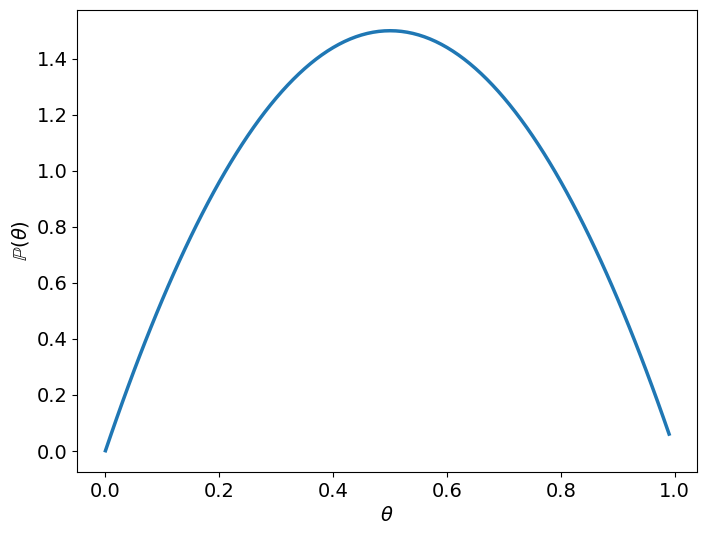

In [5]:
thetas = torch.arange(0, 1, 0.01)
plt.plot(thetas, dist.Beta(2, 2).log_prob(thetas).exp())
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{P}(\theta)$");

Create a Dataset from 10 coin flips with a true headsrate of 75%

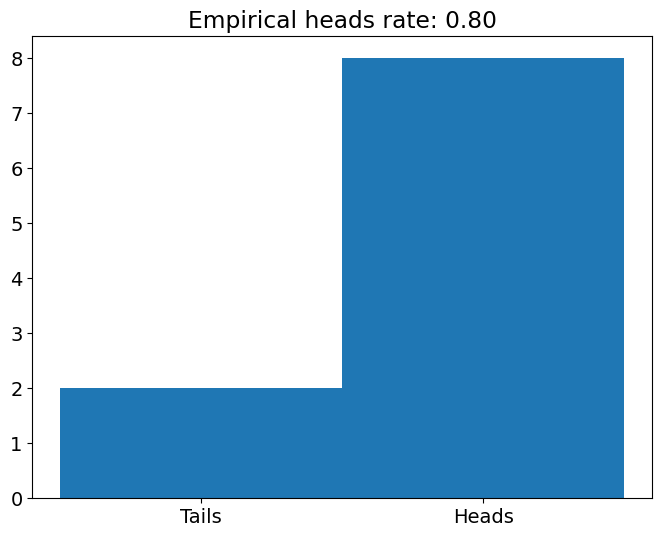

In [6]:
true_theta = 0.75
true_y = dist.Bernoulli(true_theta)

N = 10
y_obs = true_y.sample((N,))

y_julia = list(map(int, y_obs.detach().tolist()))

plt.hist(y_obs.numpy(), bins=2)
plt.xticks([0.25, 0.75], ["Tails", "Heads"])
plt.title(f"Empirical heads rate: {y_obs.mean() :.2f}");

## Stan

In [7]:
stan_model = """
data {
  int<lower=1> N;
  int<lower=0,upper=1> y[N];
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  theta ~ beta(2, 2);
  for (n in 1:N)
    y[n] ~ bernoulli(theta);
}
"""

In [8]:
coin_flip_data = {
    "N": 10,
    "y": list(map(int, y_obs.detach().tolist()))
}
import json


If PyStan works on your system you can use the next Cell, which is simpler, otherwise you can run the cell after that which uses cmdstan.

In [ ]:
# Below version is simpler and might work for you but not on my machine
built_model = stan.build(stan_model, data=coin_flip_data, random_seed=SEED)
posterior = built_model.sample(num_chains=4, num_samples=1000)

In [9]:
# This version is a bit more complicated
from cmdstanpy import CmdStanModel

text_file = open("./coin.stan", "w")
text_file.write(stan_model)
text_file.close()

data_stan = json.dumps(coin_flip_data)
text_file = open("./coin.data.json", "w")
text_file.write(data_stan)
text_file.close()

model = CmdStanModel(stan_file="./coin.stan")
print(model.exe_info())
posterior = model.sample(data="./coin.data.json", chains=4, seed=SEED)

21:53:49 - cmdstanpy - INFO - compiling stan file /Users/nathanaeltu/Library/Mobile Documents/com~apple~CloudDocs/Documents/Hybrid20/Workshop_23_11_2022 copy 2/coin.stan to exe file /Users/nathanaeltu/Library/Mobile Documents/com~apple~CloudDocs/Documents/Hybrid20/Workshop_23_11_2022 copy 2/coin
21:53:55 - cmdstanpy - INFO - compiled model executable: /Users/nathanaeltu/Library/Mobile Documents/com~apple~CloudDocs/Documents/Hybrid20/Workshop_23_11_2022 copy 2/coin
21:53:55 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
21:53:55 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/var/folders/hy/96_k5hb92w7_wgb75m0yljdw0000gn/T/com.apple.shortcuts.mac-helper/tmpwwcl78zj/tmpaiwm71lx.hpp /var/folders/hy/96_k5hb92w7_wgb75m0yljdw0000gn/T/com.apple.shortcuts.mac-helper/tmpwwcl78zj/tmpaiwm71lx.stan
Warning in '/var/folders/hy/96_k5hb92w7_wgb75m0yljdw0000gn/T/com.apple.shortcuts.mac-helper/tmpwwcl78zj/tmpaiwm71lx.stan', line 4, column 2: Declarati

{'stan_version_major': '2', 'stan_version_minor': '30', 'stan_version_patch': '0', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:53:55 - cmdstanpy - INFO - CmdStan done processing.


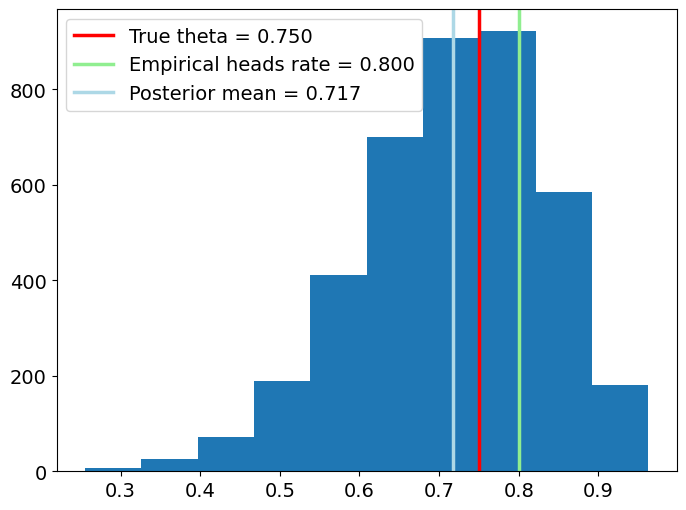

In [10]:
trace = posterior.draws_pd()

plt.hist(trace['theta'][:])
plt.axvline(true_theta, color="red", label=f"True theta = {true_theta :.03f}")
plt.axvline(
    y_obs.mean(),
    color="lightgreen",
    label=f"Empirical heads rate = {y_obs.mean() :.03f}",
)
plt.axvline(
    trace['theta'][:].mean(),
    color="lightblue",
    label=f"Posterior mean = {trace['theta'][:].mean():.03f}",
)
plt.legend();

## Beanmachine

In [11]:
#Heads rate
@bm.random_variable
def theta():
    return dist.Beta(2, 2)

#coin flip
@bm.random_variable
def y(i: int):
    return dist.Bernoulli(theta())

In [12]:
observations = {
    y(0): y_obs[0],
    y(1): y_obs[1],
    y(2): y_obs[2],
    y(3): y_obs[3],
    y(4): y_obs[4],
    y(5): y_obs[5],
    y(6): y_obs[6],
    y(7): y_obs[7],
    y(8): y_obs[8],
    y(9): y_obs[9],
}

In [14]:
samples = bm.SingleSiteAncestralMetropolisHastings().infer(
    queries=[theta()],
    observations=observations,
    num_samples=1000,
    num_chains=4,
)

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples collected:   0%|          | 0/1000 [00:00<?, ?it/s]

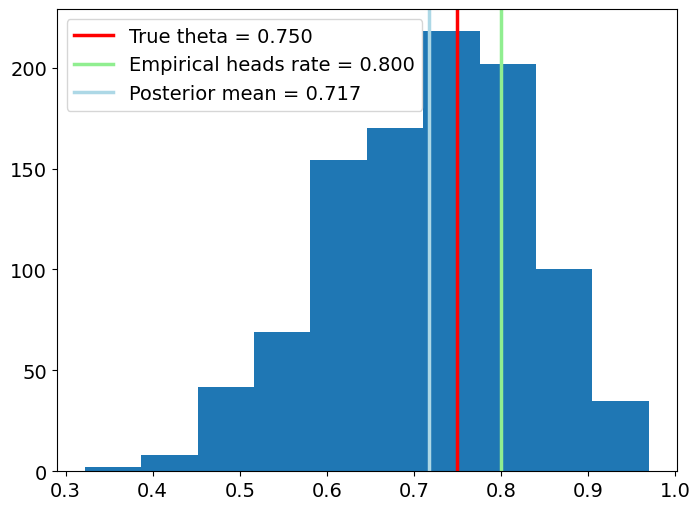

In [15]:
theta_for_four_chains = samples[theta()].detach()
theta_for_first_chain = theta_for_four_chains[0]
plt.hist(theta_for_first_chain.numpy())
plt.axvline(true_theta, color="red", label=f"True theta = {true_theta :.03f}")
plt.axvline(
    y_obs.mean(),
    color="lightgreen",
    label=f"Empirical heads rate = {y_obs.mean() :.03f}",
)
plt.axvline(
    theta_for_first_chain.mean(),
    color="lightblue",
    label=f"Posterior mean = {theta_for_first_chain.mean() :.03f}",
)
plt.legend();

## Pyro

In [17]:
import pyro.distributions as distP

pyro.clear_param_store()

def simple_model(flips=None):
    a = pyro.param("a", lambda: torch.tensor(2.0))
    b = pyro.param("b", lambda: torch.tensor(2.0))
    theta = pyro.sample("theta", distP.Beta(a,b))

    with pyro.plate("data"):
        return pyro.sample("obs", dist.Bernoulli(theta), obs=flips)


Elbo loss: 7.328215956687927
Elbo loss: 5.731644630432129
Elbo loss: 5.569789469242096
Elbo loss: 4.839040517807007
Elbo loss: 5.26840078830719
Elbo loss: 5.369673132896423
Elbo loss: 5.238873839378357
Elbo loss: 5.674679279327393
Elbo loss: 5.330271601676941
Elbo loss: 5.172573566436768
a 8.2562475
b 2.4111488
AutoNormal.locs.theta 1.3645742
AutoNormal.scales.theta 0.5492602


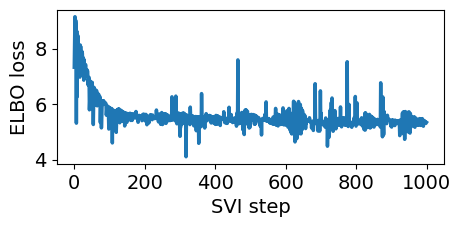

In [12]:
guide = pyro.infer.autoguide.AutoNormal(simple_model)

adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(simple_model, guide, adam, elbo)

losses = []
for step in range(1000): 
    loss = svi.step(y_obs)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

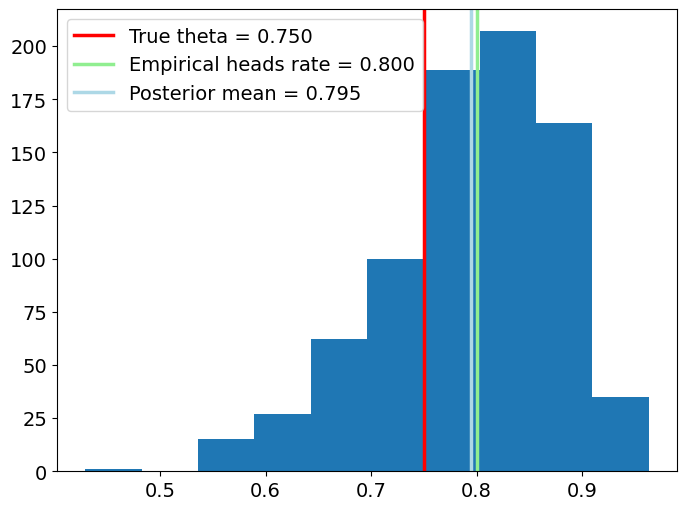

In [121]:
with pyro.plate("samples", 800, dim=-1):
    samples = guide()

gamma = samples["theta"]

plt.hist(gamma.detach().cpu().numpy())
plt.axvline(true_theta, color="red", label=f"True theta = {true_theta :.03f}")
plt.axvline(
    y_obs.mean(),
    color="lightgreen",
    label=f"Empirical heads rate = {y_obs.mean() :.03f}",
)
plt.axvline(
    gamma.detach().cpu().mean(),
    color="lightblue",
    label=f"Posterior mean = {gamma.detach().cpu().mean() :.03f}",
)
plt.legend();

## Turing

In [132]:
%%julia
data = $y_julia

@model function coinflip(y)
    theta ~ Beta(2, 2)
    N = length(y)
    for n in 1:N
        y[n] ~ Bernoulli(theta)
    end
end

chain = sample(coinflip(data), MH(), 1000)

Sampling   0%|                                          |  ETA: N/A
Sampling   0%|▎                                         |  ETA: 0:00:28
Sampling   1%|▍                                         |  ETA: 0:00:14
Sampling   2%|▋                                         |  ETA: 0:00:09
Sampling   2%|▉                                         |  ETA: 0:00:07
Sampling   2%|█                                         |  ETA: 0:00:06
Sampling   3%|█▎                                        |  ETA: 0:00:05
Sampling   4%|█▌                                        |  ETA: 0:00:04
Sampling   4%|█▋                                        |  ETA: 0:00:03
Sampling   4%|█▉                                        |  ETA: 0:00:03
Sampling   5%|██▏                                       |  ETA: 0:00:03
Sampling   6%|██▎                                       |  ETA: 0:00:02
Sampling   6%|██▌                                       |  ETA: 0:00:02
Sampling   6%|██▊                                       |  ETA: 0:00

<PyCall.jlwrap MCMC chain (1000×2×1 Array{Float64, 3})>

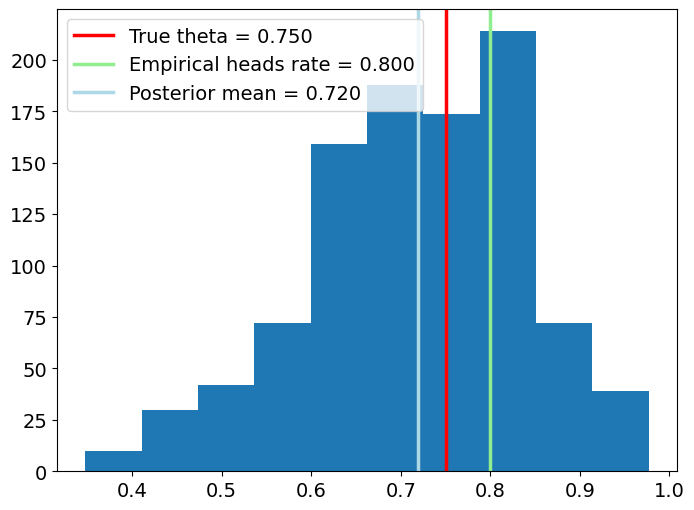

In [133]:
py_theta = %julia chain[:theta]

trace = pd.DataFrame(py_theta[:])
plt.hist(trace[0][:])
plt.axvline(true_theta, color="red", label=f"True theta = {true_theta :.03f}")
plt.axvline(
    y_obs.mean(),
    color="lightgreen",
    label=f"Empirical heads rate = {y_obs.mean() :.03f}",
)
plt.axvline(
    trace[0].mean(),
    color="lightblue",
    label=f"Posterior mean = {trace[0].mean():.03f}",
)
plt.legend();

## Gen

In [18]:
%%julia
@gen function my_model(ys::Vector{Bool})
    theta ~ beta(2, 2)
    for (i, y) in enumerate(ys)
        @trace(bernoulli(theta), "y-$i")
    end
end;

In [19]:
%%julia
function my_inference_program(ys::Vector{Bool}, num_iters::Int)
    # Create a set of constraints fixing 
    # y to the observed y values
    constraints = choicemap()
    for (i, y) in enumerate(ys)
        constraints["y-$i"] = y
    end
    
    # Run the model, constrained by `constraints`,
    # to get an initial execution trace
    (trace, _) = generate(my_model, (ys,), constraints)
    
    xs = Float64[]

    for iter=1:num_iters
        (trace, _) = metropolis_hastings(trace, select(:theta))
        push!(xs, trace[:theta])
    end
    
    # From the final trace, read out all biases
    return xs
end;

In [10]:
%%julia

ys = [true, true, false, true, true, true, false, true, true, true]
result = my_inference_program(ys, 4000)
result

array([0.45338087, 0.45338087, 0.44620606, ..., 0.68024524, 0.64355666,
       0.8025539 ])

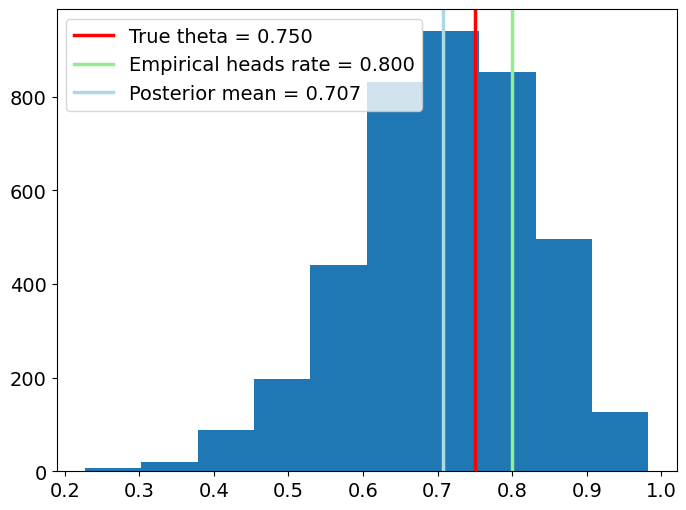

In [11]:
gen_result = %julia result
trace = pd.DataFrame(gen_result)
plt.hist(trace[0][:])
plt.axvline(true_theta, color="red", label=f"True theta = {true_theta :.03f}")
plt.axvline(
    y_obs.mean(),
    color="lightgreen",
    label=f"Empirical heads rate = {y_obs.mean() :.03f}",
)
plt.axvline(
    trace[0].mean(),
    color="lightblue",
    label=f"Posterior mean = {trace[0].mean():.03f}",
)
plt.legend();